In [1]:
import os
import torch
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T

torch.manual_seed(2025)

class CustomDataset(Dataset):
    def __init__(self, root, data_type, transformations=None, im_files=[".png", ".jpg"]):
        
        self.transformations = transformations
        if data_type == "train":
            self.im_paths = glob(f"{root}/{data_type}/*/*{[im_file for im_file in im_files]}")
        elif data_type == "test":
            self.im_paths = glob(f"{root}/{data_type}/*/*{[im_file for im_file in im_files]}")

        self.cls_names, self.cls_counts = {}, {}
        count = 0
        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1        
        
    def get_class(self, path): return os.path.dirname(path).split("/")[-1]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None:
            im = self.transformations(im)

        return im, gt

    @classmethod
    def get_dls(cls, root, transformations, bs, split=[0.9, 0.05, 0.05], ns=4):
        
        tr_ds = cls(root=root, data_type="train", transformations=transformations)
        ts_ds = cls(root=root, data_type="test", transformations=transformations)
        cls_names, cls_counts = tr_ds.cls_names, tr_ds.cls_counts

        total_len = len(tr_ds)
        tr_len = int(total_len * split[0])
        vl_len = total_len - tr_len        

        tr_ds, vl_ds = random_split(tr_ds, [tr_len, vl_len])

        tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
        val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns)
        ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)

        return tr_dl, val_dl, ts_dl, cls_names, [cls_counts, ts_ds.cls_counts]

root = "/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset"
mean, std, im_size, bs = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224, 32
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)])

tr_dl, val_dl, ts_dl, classes, cls_counts = CustomDataset.get_dls(root=root, transformations=tfs, bs=bs)
print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)
288
32
1279
{'No Impairment': 0, 'Very Mild Impairment': 1, 'Moderate Impairment': 2, 'Mild Impairment': 3}

288
32
1279
{'No Impairment': 0, 'Very Mild Impairment': 1, 'Moderate Impairment': 2, 'Mild Impairment': 3}


{'No Impairment': 0,
 'Very Mild Impairment': 1,
 'Moderate Impairment': 2,
 'Mild Impairment': 3}

Data analysis is in process...

Data analysis is in process...



<ipython-input-2-d49c985fdab8>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 90)


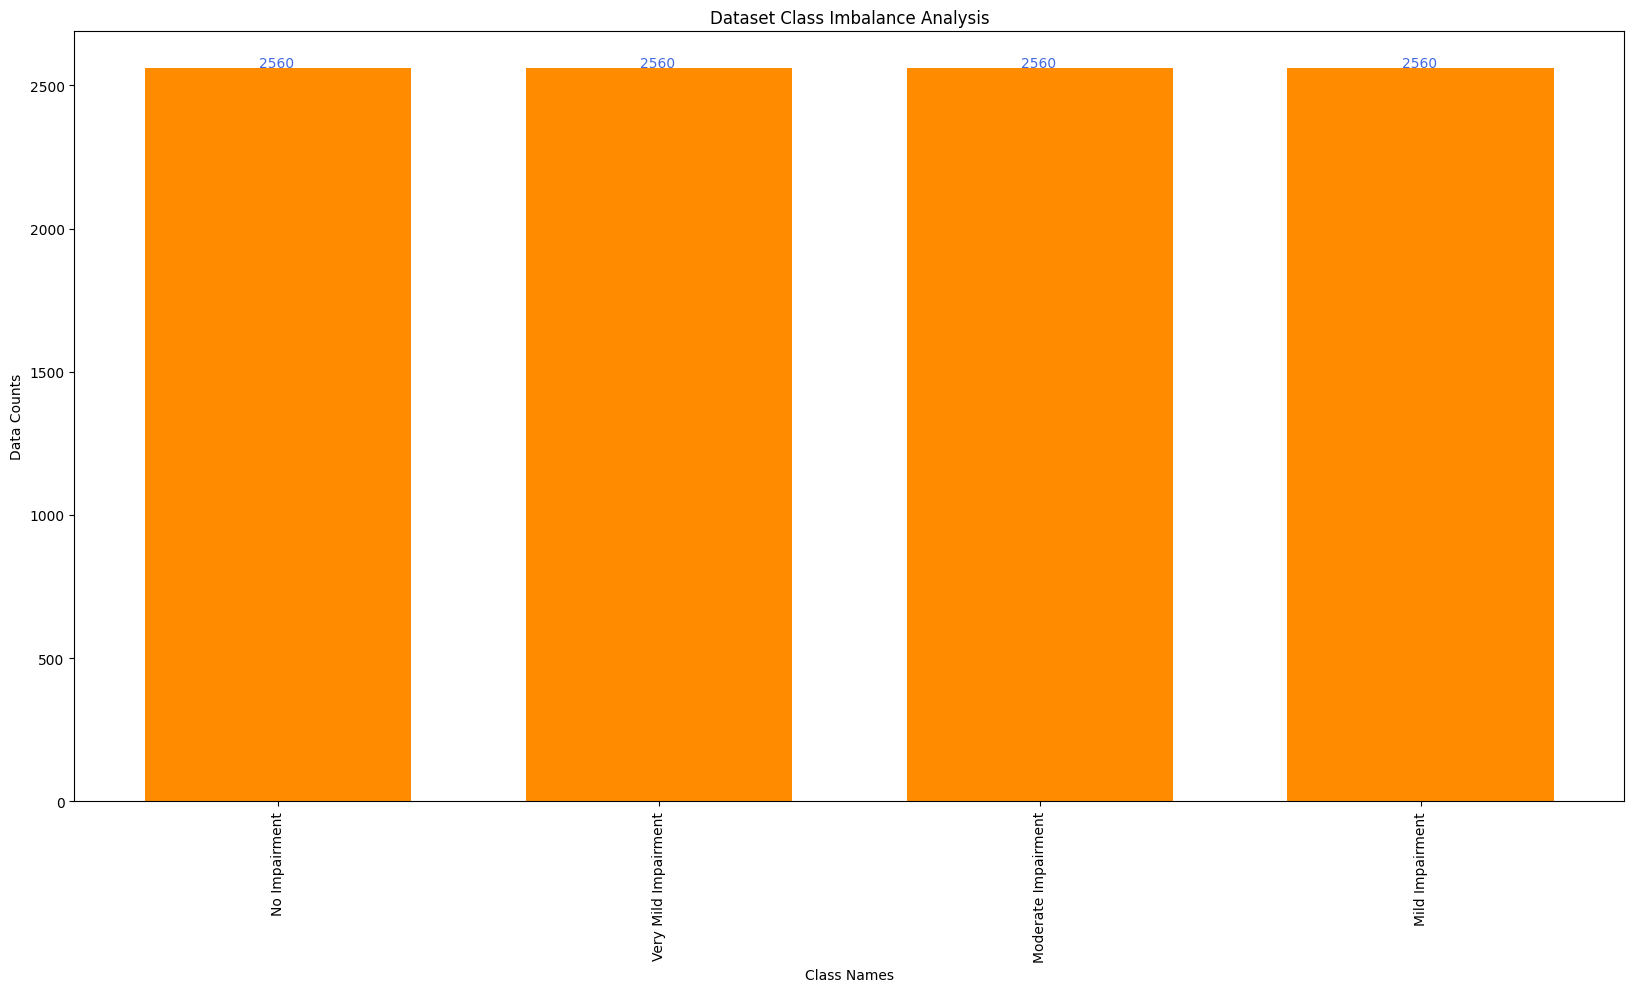

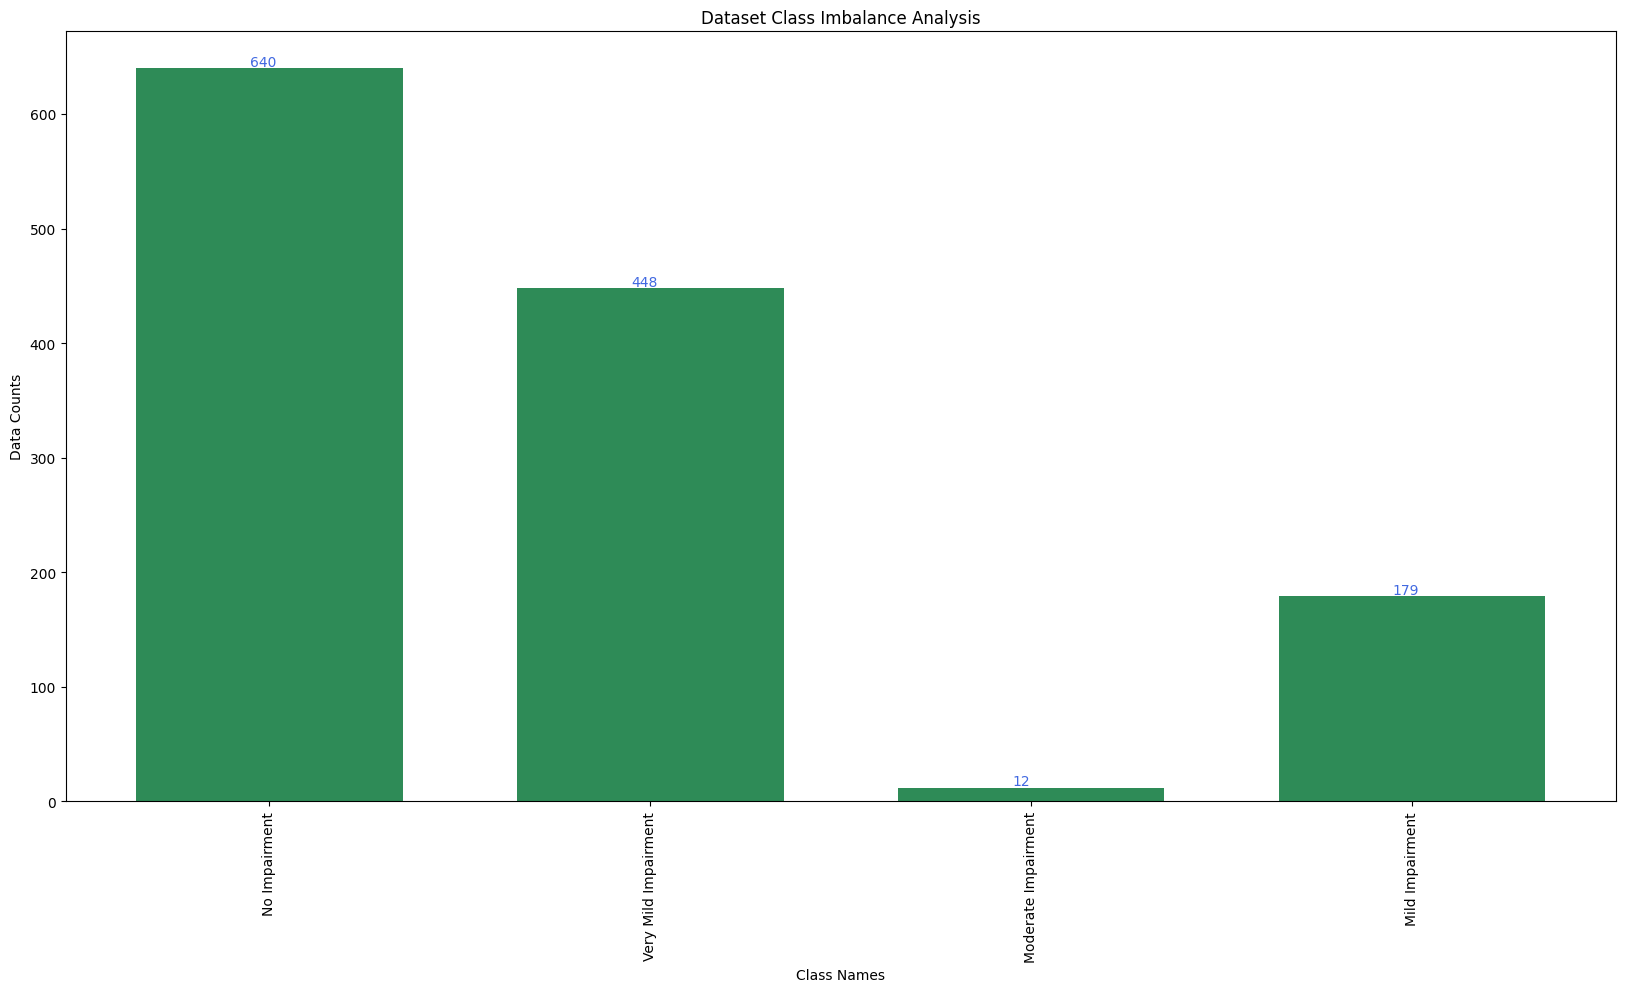

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms as T

class Visualization:

    def __init__(self, vis_datas, n_ims, rows, cmap=None, cls_names=None, cls_counts=None, t_type="rgb"):
        self.n_ims, self.rows = n_ims, rows
        self.t_type, self.cmap = t_type, cmap
        self.cls_names = cls_names
        self.colors = ["darkorange", "seagreen", "salmon"] 
        
        data_names = ["train", "val", "test"]
        self.vis_datas = {data_names[i]: vis_datas[i] for i in range(len(vis_datas))}
        if isinstance(cls_counts, list): 
            self.analysis_datas = {data_names[i]: cls_counts[i] for i in range(len(cls_counts))}
        else: 
            self.analysis_datas = {"all": cls_counts}

    def tn2np(self, t):
        gray_tfs = T.Compose([T.Normalize(mean=[0.], std=[1/0.5]), T.Normalize(mean=[-0.5], std=[1])])
        rgb_tfs = T.Compose([T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]), 
                             T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])
        
        invTrans = gray_tfs if self.t_type == "gray" else rgb_tfs
        
        return (invTrans(t) * 255).detach().squeeze().cpu().permute(1, 2, 0).numpy().astype(np.uint8) if self.t_type == "gray" \
               else (invTrans(t) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)

    def plot(self, rows, cols, count, im, title="Original Image"):
        plt.subplot(rows, cols, count)
        plt.imshow(self.tn2np(im))
        plt.axis("off")
        plt.title(title)
        return count + 1

    def vis(self, data, save_name):
        print(f"{save_name.upper()} Data Visualization is in process...\n")
        assert self.cmap in ["rgb", "gray"], "Please choose rgb or gray cmap"
        cmap = "viridis" if self.cmap == "rgb" else None
        cols = self.n_ims // self.rows
        count = 1

        plt.figure(figsize=(25, 20))
        indices = [np.random.randint(low=0, high=len(data) - 1) for _ in range(self.n_ims)]

        for idx, index in enumerate(indices):
            if count == self.n_ims + 1: break
            image, label = data[index]
            plt.subplot(self.rows, self.n_ims // self.rows, idx + 1)

            if cmap:
                plt.imshow(self.tn2np(image), cmap=cmap)
            else:
                plt.imshow(self.tn2np(image))

            plt.axis('off')
            if self.cls_names is not None:
                plt.title(f"GT -> {self.cls_names[int(label)]}")
            else:
                plt.title(f"GT -> {label}")
        
        plt.show()

    def data_analysis(self, cls_counts, save_name, color):
        print("Data analysis is in process...\n")
        width, text_width, text_height = 0.7, 0.05, 2
        cls_names = list(cls_counts.keys())
        counts = list(cls_counts.values())
        _, ax = plt.subplots(figsize=(20, 10))
        indices = np.arange(len(counts))
        ax.bar(indices, counts, width, color=color)
        ax.set_xlabel("Class Names", color="black")
        ax.set_xticklabels(cls_names, rotation = 90)
        ax.set(xticks=indices, xticklabels=cls_names)
        ax.set_ylabel("Data Counts", color="black")
        ax.set_title("Dataset Class Imbalance Analysis")
        for i, v in enumerate(counts):
            ax.text(i - text_width, v + text_height, str(v), color="royalblue")
    
    def plot_pie_chart(self, cls_counts):
        print("Generating pie chart...\n")
        labels = list(cls_counts.keys())
        sizes = list(cls_counts.values())
        explode = [0.1] * len(labels)  # To highlight all slices equally (optional)
        
        plt.figure(figsize=(8, 8))
        plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
        plt.title("Class Distribution")
        plt.axis("equal")  # Equal aspect ratio ensures the pie chart is circular
        plt.show()

    def visualization(self): [self.vis(data.dataset, save_name) for (save_name, data) in self.vis_datas.items()]
        
    def analysis(self): [self.data_analysis(data, save_name, color) for (save_name, data), color in zip(self.analysis_datas.items(), self.colors)]

    def pie_chart(self): [self.plot_pie_chart(data) for data in self.analysis_datas.values()]
        
vis = Visualization(vis_datas = [tr_dl, ts_dl], n_ims = 18, rows = 6, cmap = "rgb", cls_names = list(classes.keys()), cls_counts = cls_counts)
vis.analysis()

Generating pie chart...



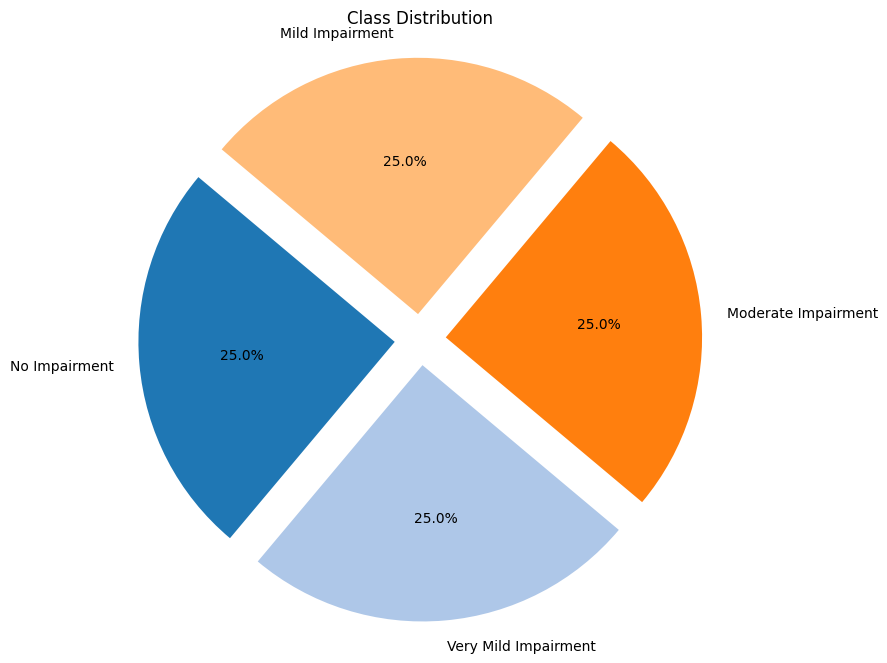

Generating pie chart...



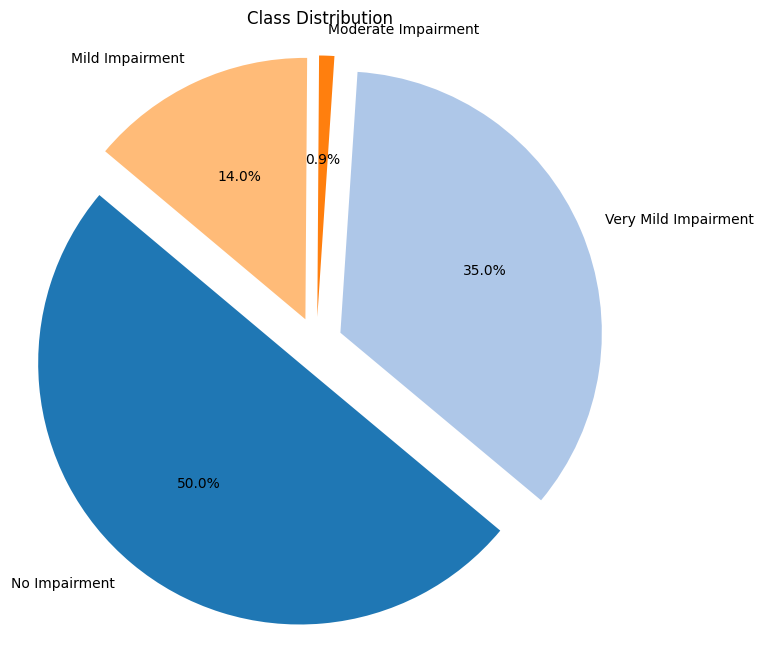

In [3]:
vis.pie_chart()

TRAIN Data Visualization is in process...



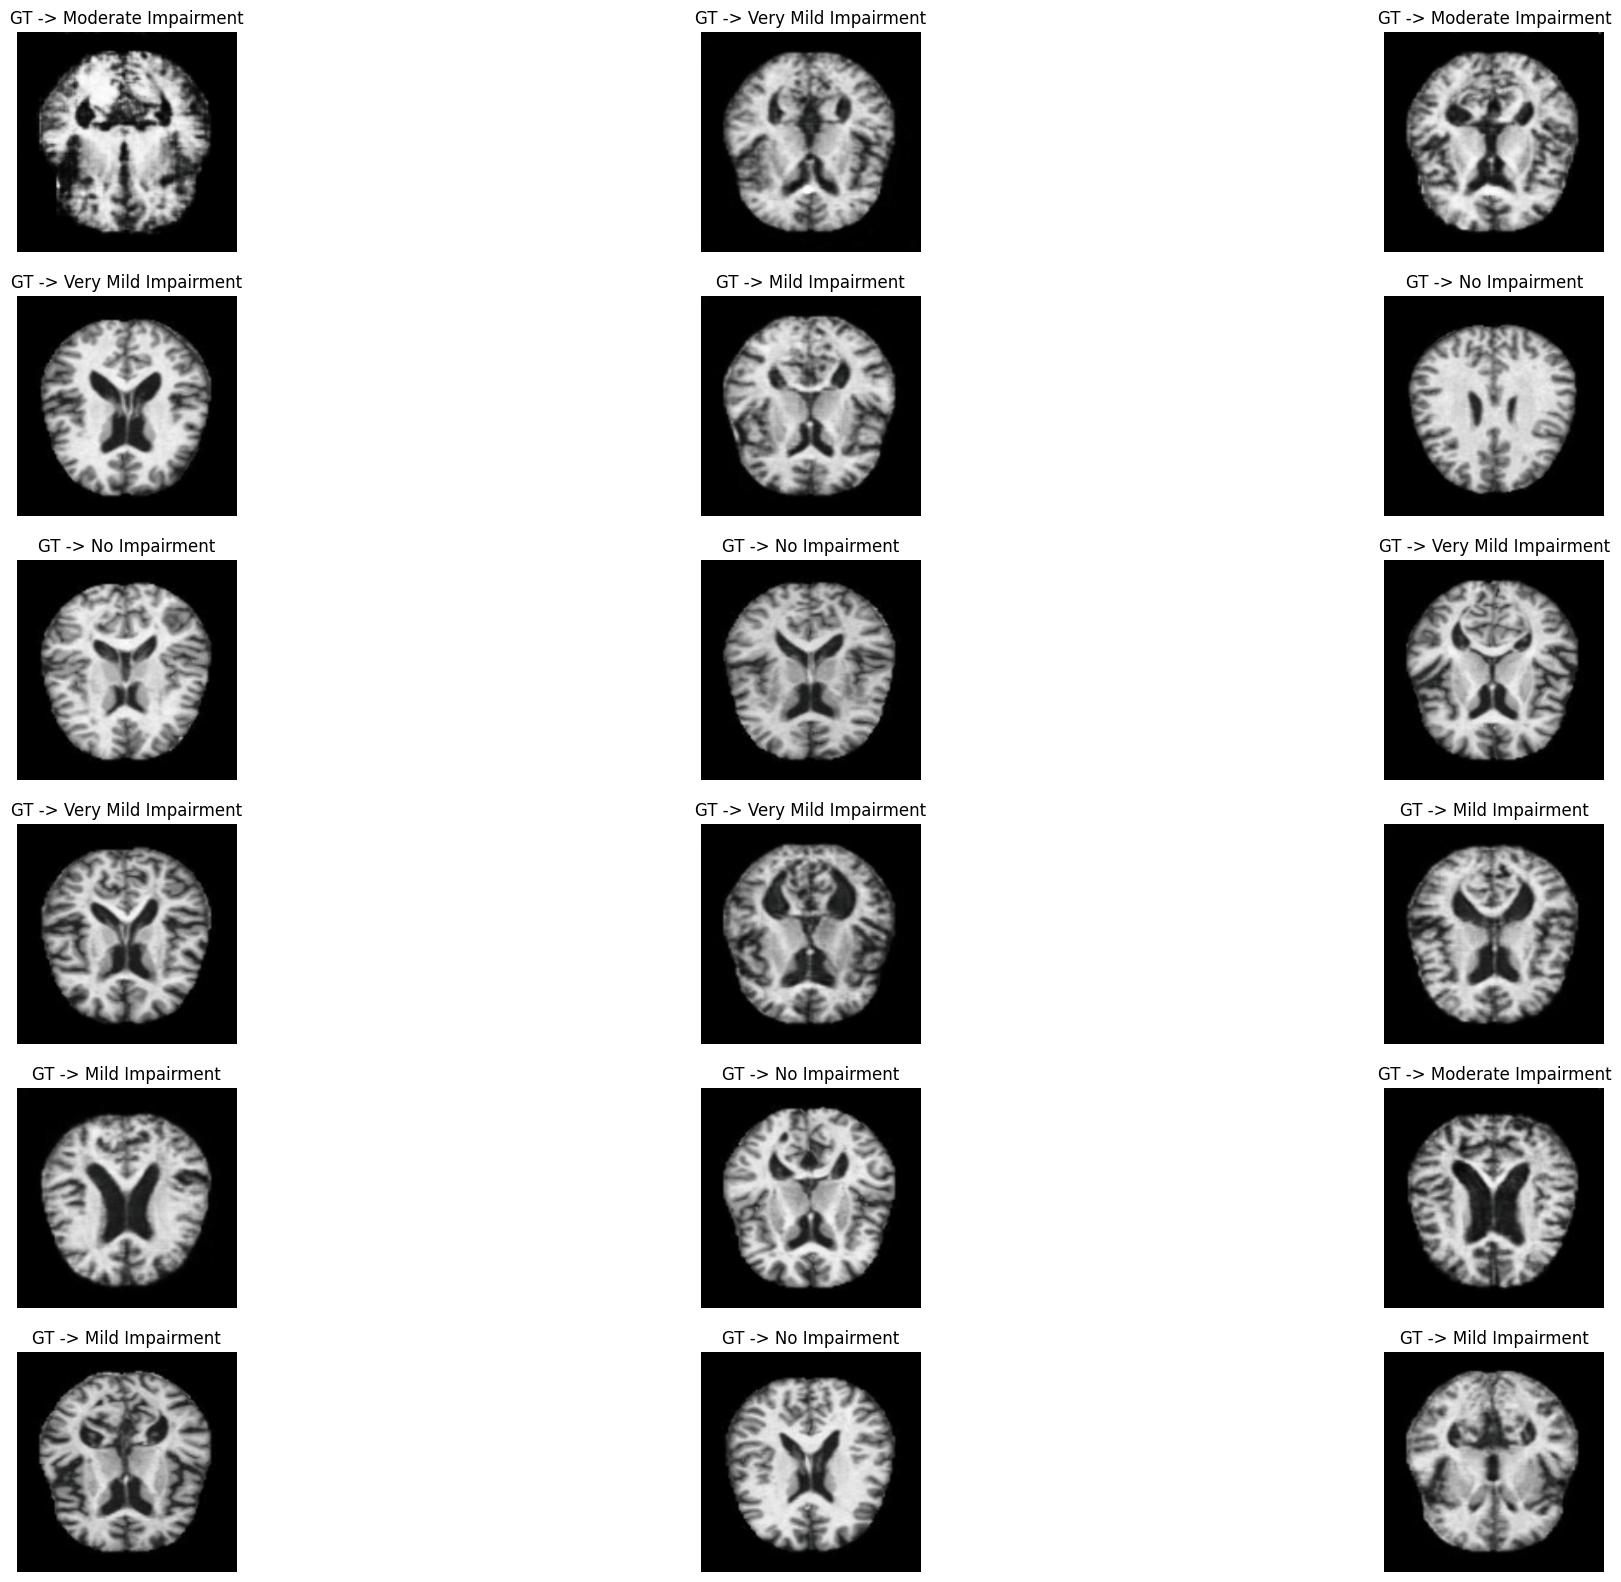

VAL Data Visualization is in process...



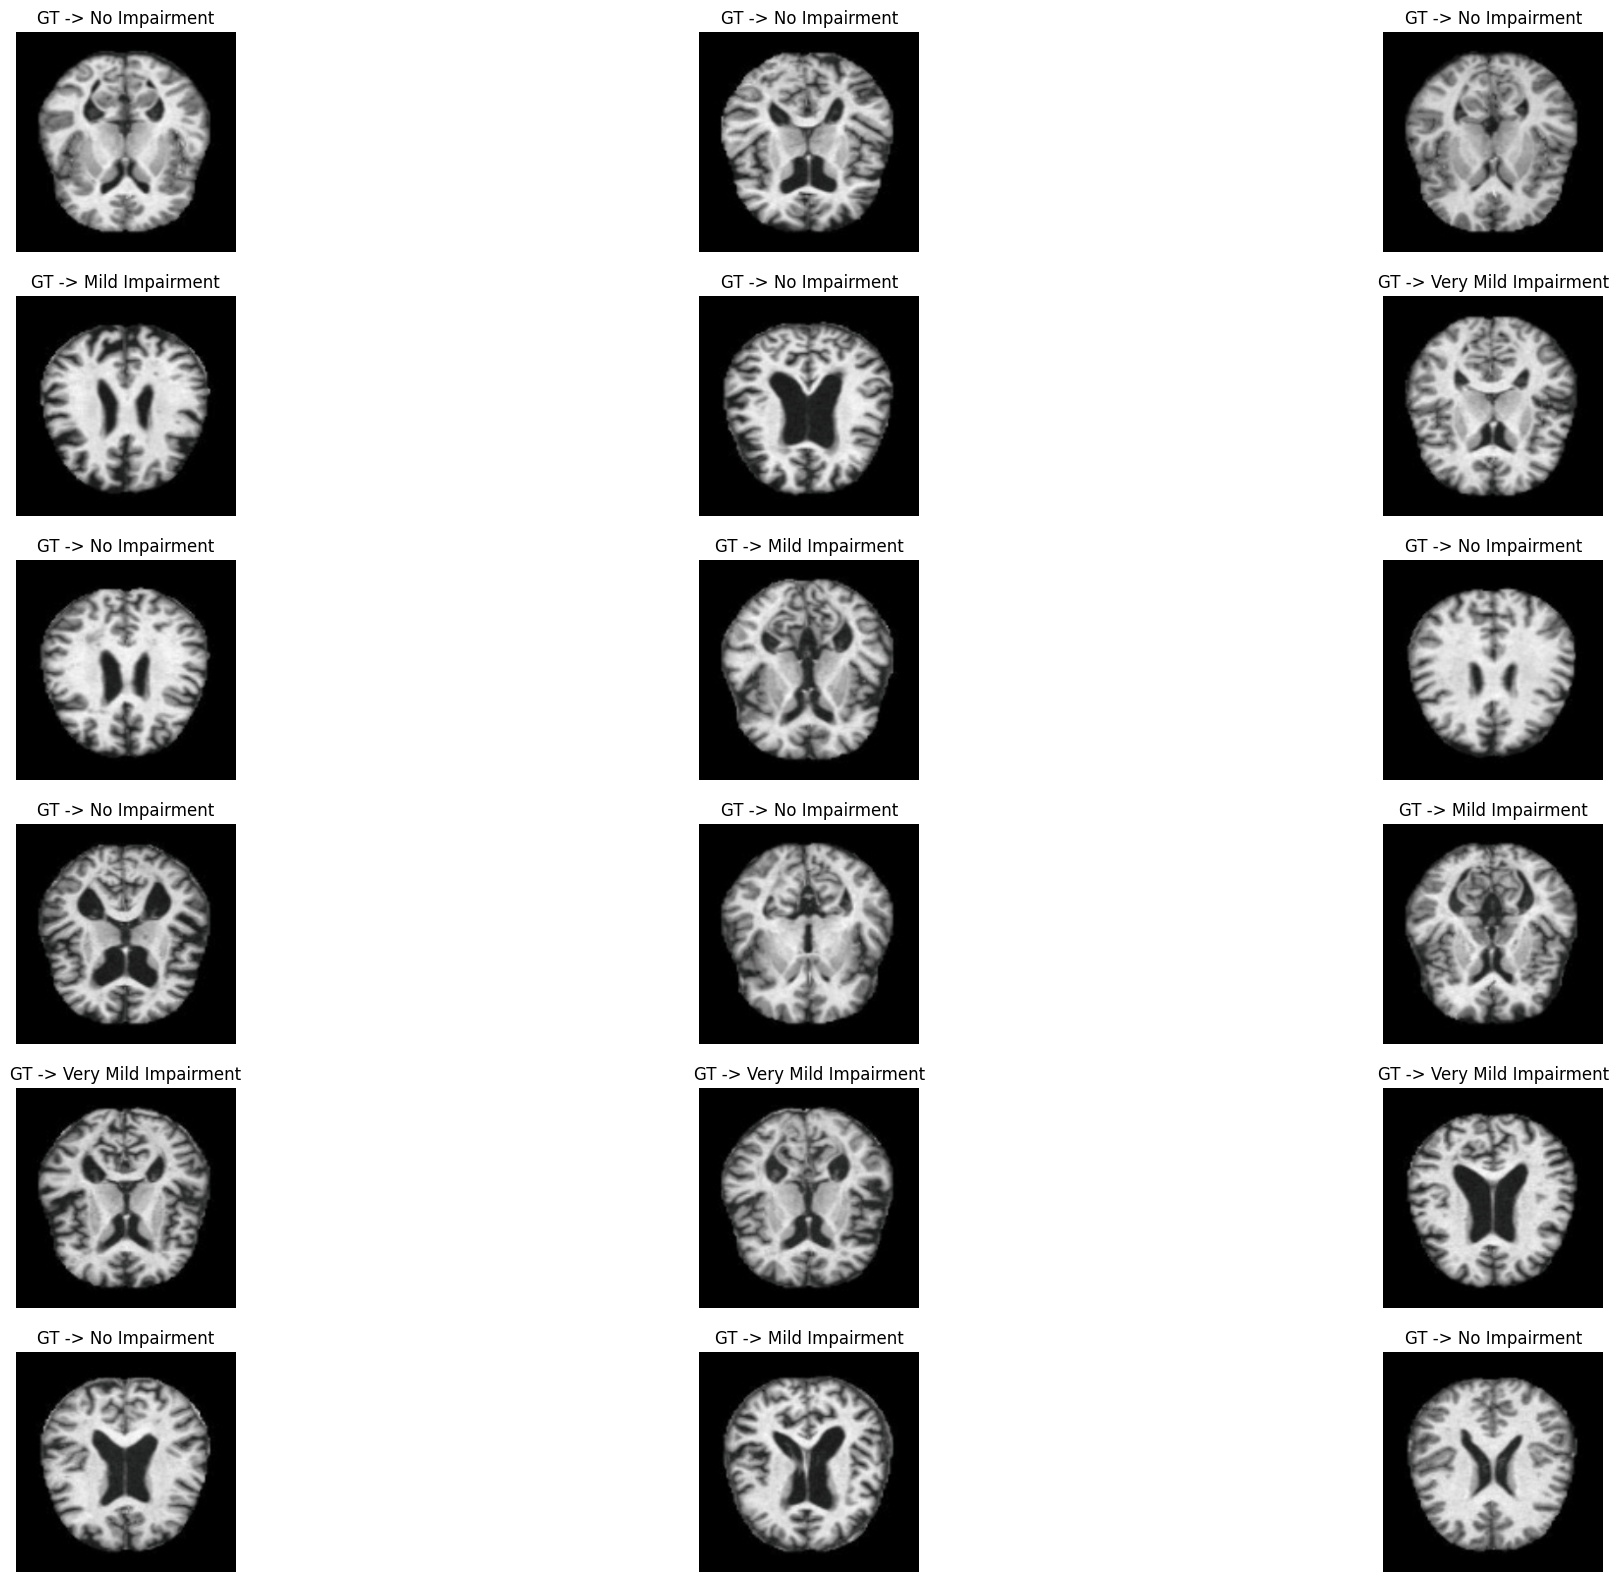

In [4]:
vis.visualization()

In [5]:
#this I need for getting the good gradscam
# import os, torchmetrics
# import timm
# from tqdm import tqdm

# class TrainValidation:
#     def __init__(self, model_name, classes, tr_dl, val_dl, device, save_dir="saved_models", save_prefix="model", lr=3e-4, epochs=50, patience=5, threshold=0.01, dev_mode = False):
#         self.model_name = model_name
#         self.classes = classes
#         self.tr_dl = tr_dl
#         self.val_dl = val_dl
#         self.save_dir = save_dir
#         self.save_prefix = save_prefix
#         self.lr = lr
#         self.epochs = epochs
#         self.patience = patience
#         self.threshold = threshold
#         self.dev_mode = dev_mode
#         self.device = device
#         self.model = timm.create_model(model_name, pretrained=True, num_classes=len(classes)).to(self.device)
#         self.loss_fn = torch.nn.CrossEntropyLoss()
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
#         self.f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(self.device)

#         os.makedirs(save_dir, exist_ok=True)

#         self.best_loss = float("inf")
#         self.best_acc = 0
#         self.not_improved = 0

#         self.tr_losses, self.val_losses = [], []
#         self.tr_accs, self.val_accs = [], []
#         self.tr_f1s, self.val_f1s = [], []

#     @staticmethod
#     def to_device(batch, device):
#         ims, gts = batch
#         return ims.to(device), gts.to(device)

#     def train_epoch(self):
#         self.model.train()
#         train_loss, train_acc = 0.0, 0.0
#         self.f1_metric.reset()

#         for idx, batch in tqdm(enumerate(self.tr_dl), desc="Training"):
#             if self.dev_mode: 
#                 if idx == 1: break
            
#             ims, gts = TrainValidation.to_device(batch = batch, device = self.device)
#             # ims, gts = self.to_device((ims, gts))
            
#             # Forward pass
#             preds = self.model(ims)
#             loss = self.loss_fn(preds, gts)
            
#             # Backward pass
#             self.optimizer.zero_grad()
#             loss.backward()
#             self.optimizer.step()
            
#             # Update metrics
#             train_loss += loss.item()
#             train_acc += (torch.argmax(preds, dim=1) == gts).sum().item()
#             self.f1_metric.update(preds, gts)

#         train_loss /= len(self.tr_dl)
#         train_acc /= len(self.tr_dl.dataset)
#         train_f1 = self.f1_metric.compute().item()
        
#         self.tr_losses.append(train_loss)
#         self.tr_accs.append(train_acc)
#         self.tr_f1s.append(train_f1)

#         return train_loss, train_acc, train_f1

#     def validate_epoch(self):
#         self.model.eval()
#         val_loss, val_acc = 0.0, 0.0
#         self.f1_metric.reset()

#         with torch.no_grad():
#             for idx, batch in tqdm(enumerate(self.val_dl), desc="Validation"):
#                 if self.dev_mode: 
#                     if idx == 1: break
#                 # ims, gts = self.to_device((ims, gts))
#                 ims, gts = TrainValidation.to_device(batch, device = self.device)
#                 preds = self.model(ims)
#                 loss = self.loss_fn(preds, gts)

#                 # Update metrics
#                 val_loss += loss.item()
#                 val_acc += (torch.argmax(preds, dim=1) == gts).sum().item()
#                 self.f1_metric.update(preds, gts)

#         val_loss /= len(self.val_dl)
#         val_acc /= len(self.val_dl.dataset)
#         val_f1 = self.f1_metric.compute().item()

#         self.val_losses.append(val_loss)
#         self.val_accs.append(val_acc)
#         self.val_f1s.append(val_f1)

#         return val_loss, val_acc, val_f1

#     def save_best_model(self, val_f1, val_loss):
#         if val_f1 > self.best_acc + self.threshold:
#             self.best_acc = val_f1            
#             save_path = os.path.join(self.save_dir, f"{self.save_prefix}_best_model.pth")
#             torch.save(self.model.state_dict(), save_path)
#             print(f"Best model saved with F1-Score: {self.best_acc:.3f}")
#             self.not_improved = 0
#         else:
#             self.not_improved += 1
#             print(f"No improvement for {self.not_improved} epoch(s).")

#     def verbose(self, epoch, metric1, metric2, metric3, process = "train"):

#         print(f"{epoch + 1}-epoch {process} process is completed!\n")
#         print(f"{epoch + 1}-epoch {process} loss          -> {metric1:.3f}")
#         print(f"{epoch + 1}-epoch {process} accuracy      -> {metric2:.3f}")
#         print(f"{epoch + 1}-epoch {process} f1-score      -> {metric3:.3f}\n")
    
#     def run(self):
#         print("Start training...")

#         for epoch in range(self.epochs):
#             if self.dev_mode: 
#                 if epoch == 1: break 
                    
#             print(f"\nEpoch {epoch + 1}/{self.epochs}:\n")

#             train_loss, train_acc, train_f1 = self.train_epoch()
#             self.verbose(epoch, train_loss, train_acc, train_f1, process = "train")

#             val_loss, val_acc, val_f1 = self.validate_epoch()
#             self.verbose(epoch, val_loss, val_acc, val_f1, process = "validation")            

#             self.save_best_model(val_f1, val_loss)

#             if self.not_improved >= self.patience:
#                 print("Early stopping triggered.")
#                 break

# model_name   = "rexnet_150"
# save_prefix  = "mri"
# save_dir     = "saved_models"
# device       = "cuda" if torch.cuda.is_available() else "cpu"

# trainer = TrainValidation(model_name = model_name, device = device, 
#                           save_prefix = save_prefix, classes = classes, 
#                           patience = 3, tr_dl = tr_dl, val_dl = val_dl, dev_mode = False)
# trainer.run()

In [6]:
#this i need to get the gradscam
# class PlotLearningCurves:
    
#     def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        
#         self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s
        
#     def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        
#         plt.plot(array_1, label = label_1, c = color_1); plt.plot(array_2, label = label_2, c = color_2)
        
#     def create_figure(self): plt.figure(figsize = (10, 5))
    
#     def decorate(self, ylabel, xlabel = "Epochs"): 
        
#         plt.xlabel(xlabel); plt.ylabel(ylabel)
#         plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
#         plt.legend(); plt.show()      
        
#     def visualize(self):
        
#         # Figure 1
#         self.create_figure()
#         self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "red", color_2 = "blue"); self.decorate(ylabel = "Loss Values")
        
#         # Figure 2
#         self.create_figure()
#         self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "orangered", color_2 = "darkgreen")
#         self.decorate(ylabel = "Accuracy Scores")
        
#         # Figure 3
#         self.create_figure()
#         self.plot(array_1 = self.tr_f1s, array_2 = self.val_f1s, label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "blueviolet", color_2 = "crimson"); self.decorate(ylabel = "F1 Scores")
        
# PlotLearningCurves(tr_losses=trainer.tr_losses, val_losses=trainer.val_losses, tr_accs=trainer.tr_accs, val_accs=trainer.val_accs, tr_f1s=trainer.tr_f1s, val_f1s=trainer.val_f1s).visualize()

In [7]:
#with augmanetation will need to uncommnet again to get the curve
import os
import torch
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
import torchmetrics
import timm
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

# === Set seed for reproducibility ===
torch.manual_seed(2025)

# === Dataset ===
class CustomDataset(Dataset):
    def __init__(self, root, data_type, transformations=None, im_files=[".png", ".jpg"]):
        self.transformations = transformations
        self.im_paths = []

        for ext in im_files:
            self.im_paths.extend(glob(f"{root}/{data_type}/*/*{ext}"))

        # === Manually set consistent class label order
        self.cls_names = {
            'Mild Impairment': 0,
            'Moderate Impairment': 1,
            'No Impairment': 2,
            'Very Mild Impairment': 3
        }

        self.cls_counts = {k: 0 for k in self.cls_names}
        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None:
            im = self.transformations(im)

        return im, gt

    @classmethod
    def get_dls(cls, root, train_tfms, test_tfms, bs, split=[0.9, 0.1], ns=4):
        full_ds = cls(root=root, data_type="train", transformations=None)
        cls_names, cls_counts = full_ds.cls_names, full_ds.cls_counts

        total_len = len(full_ds)
        tr_len = int(total_len * split[0])
        vl_len = total_len - tr_len
        tr_ds, vl_ds = random_split(full_ds, [tr_len, vl_len])

        tr_ds.dataset.transformations = train_tfms
        vl_ds.dataset.transformations = test_tfms

        ts_ds = cls(root=root, data_type="test", transformations=test_tfms)

        tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
        val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns)
        ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)

        return tr_dl, val_dl, ts_dl, cls_names, [cls_counts, ts_ds.cls_counts]

# === Transforms ===
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
im_size = 224
bs = 32

train_tfs = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop(im_size, padding=4),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.2),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.RandomGrayscale(p=0.1),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

test_tfs = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# === Load data ===
root = "/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset"
tr_dl, val_dl, ts_dl, classes, cls_counts = CustomDataset.get_dls(root=root, train_tfms=train_tfs, test_tfms=test_tfs, bs=bs)

# === Extract train_labels ===
train_labels = []
for i in tr_dl.dataset.indices:
    _, label = tr_dl.dataset.dataset[i]
    train_labels.append(label)

# === Training class ===
class TrainValidation:
    def __init__(self, model_name, classes, tr_dl, val_dl, train_labels, device,
                 save_dir="saved_models", save_prefix="model", lr=1e-4, epochs=20, patience=5, threshold=0.01, dev_mode=False):
        self.model_name = model_name
        self.classes = classes
        self.tr_dl = tr_dl
        self.val_dl = val_dl
        self.device = device
        self.save_dir = save_dir
        self.save_prefix = save_prefix
        self.lr = lr
        self.epochs = epochs
        self.patience = patience
        self.threshold = threshold
        self.dev_mode = dev_mode

        self.model = timm.create_model(model_name, pretrained=True, num_classes=len(classes)).to(self.device)
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
        weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
        self.loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)
        # self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=epochs)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( self.optimizer, mode='max', factor=0.5, patience=2, verbose=True)

        self.f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(self.device)
        os.makedirs(save_dir, exist_ok=True)

        self.best_f1 = 0
        self.not_improved = 0

        self.tr_losses, self.val_losses = [], []
        self.tr_accs, self.val_accs = [], []
        self.tr_f1s, self.val_f1s = [], []

    @staticmethod
    def to_device(batch, device):
        ims, gts = batch
        return ims.to(device), gts.to(device)

    def train_epoch(self):
        self.model.train()
        total_loss, correct = 0.0, 0
        self.f1_metric.reset()

        for idx, batch in tqdm(enumerate(self.tr_dl), desc="Training", total=len(self.tr_dl)):
            if self.dev_mode and idx > 1: break
            ims, gts = self.to_device(batch, self.device)

            preds = self.model(ims)
            loss = self.loss_fn(preds, gts)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            correct += (preds.argmax(1) == gts).sum().item()
            self.f1_metric.update(preds, gts)

        avg_loss = total_loss / len(self.tr_dl)
        avg_acc = correct / len(self.tr_dl.dataset)
        avg_f1 = self.f1_metric.compute().item()

        self.tr_losses.append(avg_loss)
        self.tr_accs.append(avg_acc)
        self.tr_f1s.append(avg_f1)

        return avg_loss, avg_acc, avg_f1

    def validate_epoch(self):
        self.model.eval()
        total_loss, correct = 0.0, 0
        self.f1_metric.reset()

        with torch.no_grad():
            for idx, batch in tqdm(enumerate(self.val_dl), desc="Validation", total=len(self.val_dl)):
                if self.dev_mode and idx > 1: break
                ims, gts = self.to_device(batch, self.device)
                preds = self.model(ims)
                loss = self.loss_fn(preds, gts)

                total_loss += loss.item()
                correct += (preds.argmax(1) == gts).sum().item()
                self.f1_metric.update(preds, gts)

        avg_loss = total_loss / len(self.val_dl)
        avg_acc = correct / len(self.val_dl.dataset)
        avg_f1 = self.f1_metric.compute().item()

        self.val_losses.append(avg_loss)
        self.val_accs.append(avg_acc)
        self.val_f1s.append(avg_f1)

        return avg_loss, avg_acc, avg_f1

    def save_best_model(self, val_f1):
        if val_f1 > self.best_f1 + self.threshold:
            self.best_f1 = val_f1
            save_path = os.path.join(self.save_dir, f"{self.save_prefix}_best_model.pth")
            torch.save(self.model.state_dict(), save_path)
            print(f"Best model saved with F1-Score: {val_f1:.3f}")
            self.not_improved = 0
        else:
            self.not_improved += 1
            print(f"No improvement for {self.not_improved} epoch(s).")

    def run(self):
        print("Start training...")
        for epoch in range(self.epochs):
            if self.dev_mode and epoch > 1: break
            print(f"\n📊 Epoch {epoch + 1}/{self.epochs}")

            train_loss, train_acc, train_f1 = self.train_epoch()
            print(f"Train — Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")

            val_loss, val_acc, val_f1 = self.validate_epoch()
            print(f"Val   — Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

            self.save_best_model(val_f1)
            self.scheduler.step(val_f1)


            if self.not_improved >= self.patience:
                print("Early stopping triggered.")
                break

# === Trainer Run ===
model_name = "rexnet_150"
save_prefix = "mri"
save_dir = "saved_models"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainer = TrainValidation(
    model_name=model_name,
    classes=classes,
    tr_dl=tr_dl,
    val_dl=val_dl,
    train_labels=train_labels,
    device=device,
    save_dir=save_dir,
    save_prefix=save_prefix,
    lr=1e-4,
    epochs=20,
    patience=5,
    threshold=0.005,
    dev_mode=False
)

trainer.run()


model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...

📊 Epoch 1/20


Training: 100%|██████████| 288/288 [00:49<00:00,  5.85it/s]


Train — Loss: 1.0521, Acc: 0.7192, F1: 0.7192


Validation: 100%|██████████| 32/32 [00:02<00:00, 11.40it/s]


Val   — Loss: 0.7090, Acc: 0.8340, F1: 0.8340
Best model saved with F1-Score: 0.834

📊 Epoch 2/20


Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]


Train — Loss: 0.6066, Acc: 0.8923, F1: 0.8923


Validation: 100%|██████████| 32/32 [00:01<00:00, 16.50it/s]


Val   — Loss: 0.6048, Acc: 0.8770, F1: 0.8770
Best model saved with F1-Score: 0.877

📊 Epoch 3/20


Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]

Train — Loss: 0.4946, Acc: 0.9556, F1: 0.9556



Validation: 100%|██████████| 32/32 [00:01<00:00, 16.73it/s]

Val   — Loss: 0.5589, Acc: 0.9082, F1: 0.9082
Best model saved with F1-Score: 0.908

📊 Epoch 4/20



Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]

Train — Loss: 0.4435, Acc: 0.9850, F1: 0.9850



Validation: 100%|██████████| 32/32 [00:01<00:00, 16.94it/s]


Val   — Loss: 0.5041, Acc: 0.9268, F1: 0.9268
Best model saved with F1-Score: 0.927

📊 Epoch 5/20


Training: 100%|██████████| 288/288 [00:47<00:00,  6.07it/s]

Train — Loss: 0.4259, Acc: 0.9885, F1: 0.9885



Validation: 100%|██████████| 32/32 [00:01<00:00, 17.00it/s]

Val   — Loss: 0.5066, Acc: 0.9248, F1: 0.9248
No improvement for 1 epoch(s).

📊 Epoch 6/20



Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]

Train — Loss: 0.4129, Acc: 0.9928, F1: 0.9928



Validation: 100%|██████████| 32/32 [00:01<00:00, 16.94it/s]


Val   — Loss: 0.4680, Acc: 0.9521, F1: 0.9521
Best model saved with F1-Score: 0.952

📊 Epoch 7/20


Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]


Train — Loss: 0.4000, Acc: 0.9978, F1: 0.9978


Validation: 100%|██████████| 32/32 [00:01<00:00, 17.31it/s]


Val   — Loss: 0.4530, Acc: 0.9580, F1: 0.9580
Best model saved with F1-Score: 0.958

📊 Epoch 8/20


Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]

Train — Loss: 0.3943, Acc: 0.9983, F1: 0.9983



Validation: 100%|██████████| 32/32 [00:01<00:00, 17.30it/s]

Val   — Loss: 0.4523, Acc: 0.9590, F1: 0.9590
No improvement for 1 epoch(s).

📊 Epoch 9/20



Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]


Train — Loss: 0.3901, Acc: 0.9991, F1: 0.9991


Validation: 100%|██████████| 32/32 [00:01<00:00, 17.13it/s]

Val   — Loss: 0.4519, Acc: 0.9580, F1: 0.9580
No improvement for 2 epoch(s).

📊 Epoch 10/20



Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]

Train — Loss: 0.3855, Acc: 0.9993, F1: 0.9993



Validation: 100%|██████████| 32/32 [00:01<00:00, 17.05it/s]

Val   — Loss: 0.4485, Acc: 0.9648, F1: 0.9648
Best model saved with F1-Score: 0.965

📊 Epoch 11/20



Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]

Train — Loss: 0.3824, Acc: 0.9996, F1: 0.9996



Validation: 100%|██████████| 32/32 [00:01<00:00, 16.48it/s]


Val   — Loss: 0.4439, Acc: 0.9707, F1: 0.9707
Best model saved with F1-Score: 0.971

📊 Epoch 12/20


Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]


Train — Loss: 0.3789, Acc: 0.9995, F1: 0.9995


Validation: 100%|██████████| 32/32 [00:01<00:00, 17.13it/s]

Val   — Loss: 0.4483, Acc: 0.9609, F1: 0.9609
No improvement for 1 epoch(s).

📊 Epoch 13/20



Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]


Train — Loss: 0.3760, Acc: 0.9997, F1: 0.9997


Validation: 100%|██████████| 32/32 [00:01<00:00, 17.14it/s]

Val   — Loss: 0.4464, Acc: 0.9580, F1: 0.9580
No improvement for 2 epoch(s).

📊 Epoch 14/20



Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]

Train — Loss: 0.3731, Acc: 0.9996, F1: 0.9996



Validation: 100%|██████████| 32/32 [00:01<00:00, 17.19it/s]

Val   — Loss: 0.4304, Acc: 0.9688, F1: 0.9688
No improvement for 3 epoch(s).

📊 Epoch 15/20



Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]


Train — Loss: 0.3670, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 32/32 [00:01<00:00, 17.14it/s]

Val   — Loss: 0.4216, Acc: 0.9707, F1: 0.9707
No improvement for 4 epoch(s).

📊 Epoch 16/20



Training: 100%|██████████| 288/288 [00:47<00:00,  6.06it/s]


Train — Loss: 0.3646, Acc: 1.0000, F1: 1.0000


Validation: 100%|██████████| 32/32 [00:01<00:00, 17.15it/s]

Val   — Loss: 0.4168, Acc: 0.9756, F1: 0.9756
No improvement for 5 epoch(s).
Early stopping triggered.


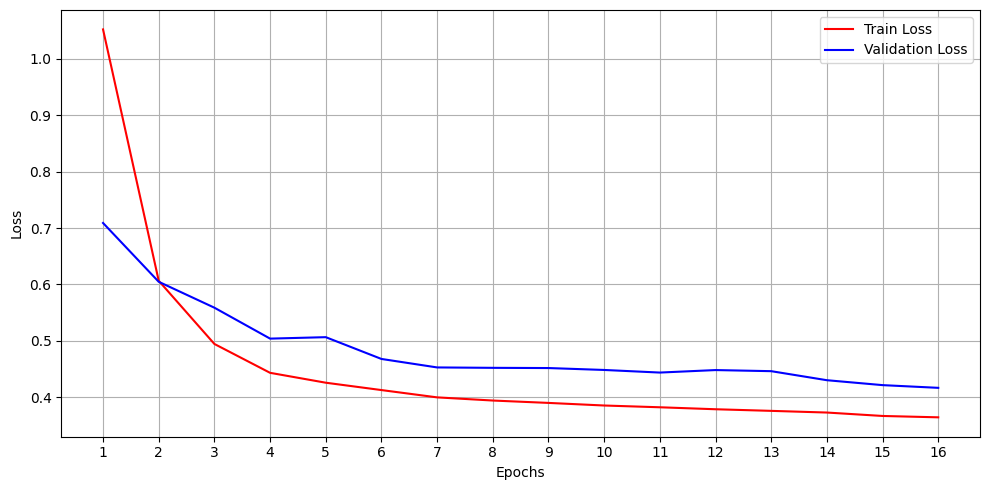

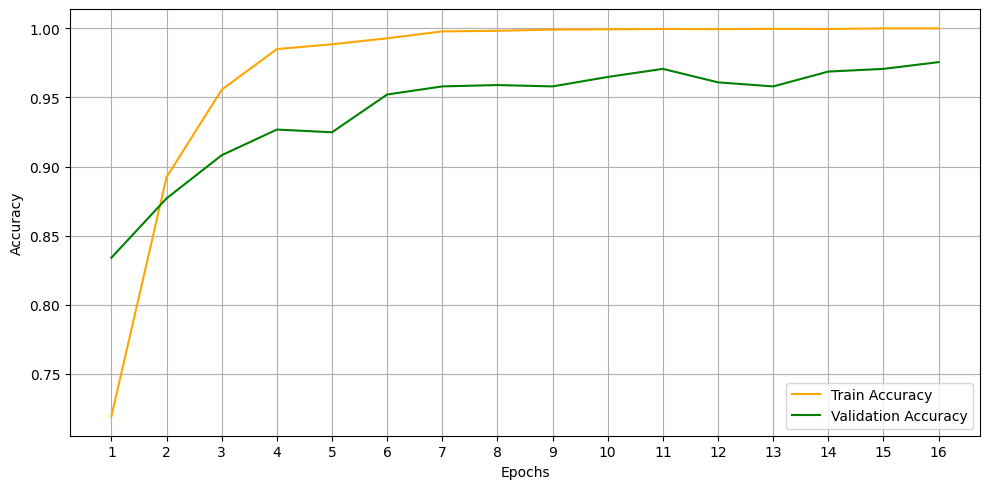

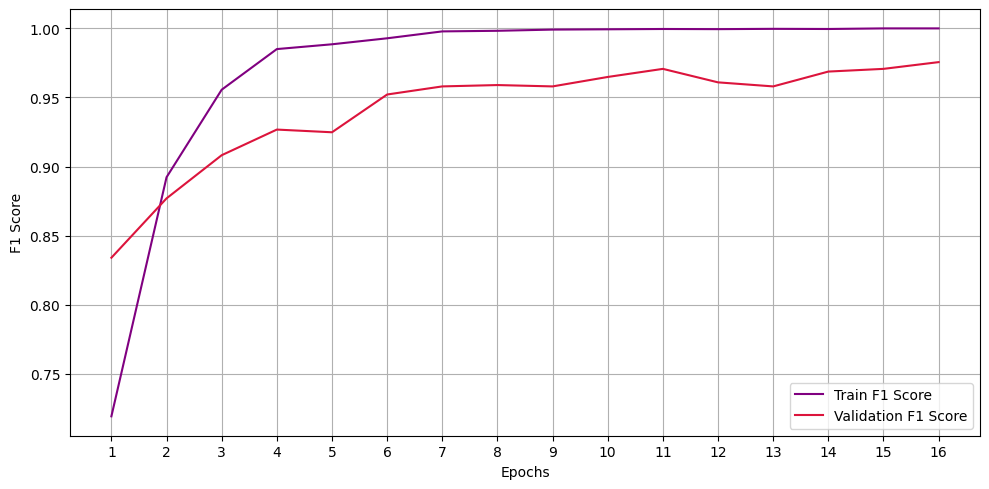

In [8]:
import matplotlib.pyplot as plt
import numpy as np

class PlotLearningCurves:
    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        self.tr_losses = tr_losses
        self.val_losses = val_losses
        self.tr_accs = tr_accs
        self.val_accs = val_accs
        self.tr_f1s = tr_f1s
        self.val_f1s = val_f1s

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        plt.plot(array_1, label=label_1, color=color_1)
        plt.plot(array_2, label=label_2, color=color_2)

    def create_figure(self):
        plt.figure(figsize=(10, 5))

    def decorate(self, ylabel, xlabel="Epochs"):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(ticks=np.arange(len(self.tr_accs)), labels=[i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def visualize(self):
        # Loss Plot
        self.create_figure()
        self.plot(self.tr_losses, self.val_losses, "Train Loss", "Validation Loss", "red", "blue")
        self.decorate(ylabel="Loss")

        # Accuracy Plot
        self.create_figure()
        self.plot(self.tr_accs, self.val_accs, "Train Accuracy", "Validation Accuracy", "orange", "green")
        self.decorate(ylabel="Accuracy")

        # F1 Score Plot
        self.create_figure()
        self.plot(self.tr_f1s, self.val_f1s, "Train F1 Score", "Validation F1 Score", "purple", "crimson")
        self.decorate(ylabel="F1 Score")

# === Call the plotting class ===
PlotLearningCurves(
    tr_losses=trainer.tr_losses,
    val_losses=trainer.val_losses,
    tr_accs=trainer.tr_accs,
    val_accs=trainer.val_accs,
    tr_f1s=trainer.tr_f1s,
    val_f1s=trainer.val_f1s
).visualize()


In [9]:
# !pip install grad-cam==1.4.6 gradio --quiet

# import os
# import random
# import cv2
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# from torchvision import transforms
# from torch.utils.data import DataLoader
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# import gradio as gr

# # === Setup ===
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Your dataset split code should have produced ts_dl, classes, etc.
# # ts_dl = ...  # test DataLoader
# # classes = {'No Impairment':0, 'Very Mild Impairment':1, 'Moderate Impairment':2, 'Mild Impairment':3}

# # 1) Build class_names from your `classes` dict in index order
# class_names = [k for k, v in sorted(classes.items(), key=lambda item: item[1])]

# # 2) Load model and weights
# model = timm.create_model("rexnet_150", pretrained=False, num_classes=len(classes)).to(device)
# state_dict = torch.load(os.path.join(save_dir, f"{save_prefix}_best_model.pth"), map_location=device)
# model.load_state_dict(state_dict)
# model.eval()

# # 3) Pick the last conv layer for Grad-CAM
# target_layer = model.features[-1]
# cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=(device.type=="cuda"))

# # ==== Inference on test set ====
# all_preds, all_labels = [], []
# with torch.no_grad():
#     for images, labels in ts_dl:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         preds = outputs.argmax(dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # ==== Test Accuracy ====
# correct = np.sum(np.array(all_preds)==np.array(all_labels))
# total = len(all_labels)
# print(f"\n=== Test Accuracy === {correct}/{total} = {100*correct/total:.2f}%\n")

# # ==== Classification Report ====
# print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

# # ==== Confusion Matrix ====
# cm = confusion_matrix(all_labels, all_preds)
# disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
# fig, ax = plt.subplots(figsize=(6,6))
# disp.plot(cmap="Blues", xticks_rotation=45, ax=ax)
# plt.title("Confusion Matrix")
# plt.tight_layout()
# plt.show()

# # ==== Grad-CAM Visualization (6 random samples) ====
# sample_indices = random.sample(range(len(ts_dl.dataset)), 6)
# sample_images = [ts_dl.dataset[i][0] for i in sample_indices]
# sample_labels = [ts_dl.dataset[i][1] for i in sample_indices]

# input_tensor = torch.stack(sample_images).to(device)
# with torch.no_grad():
#     preds = model(input_tensor).argmax(dim=1)

# # Generate CAMs
# targets = [ClassifierOutputTarget(p.item()) for p in preds]
# cam_maps = cam(input_tensor, targets=targets)

# fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# for i in range(6):
#     img = sample_images[i].cpu().permute(1,2,0).numpy()
#     # un-normalize: mean/std from your test_tfms
#     img = (img * np.array(std)) + np.array(mean)
#     img = np.clip(img, 0, 1)

#     cam_map = cv2.resize(cam_maps[i], (img.shape[1], img.shape[0]))
#     overlay = show_cam_on_image(img, cam_map, use_rgb=True)

    

#     ax = axs[i//3, i%3]
#     ax.imshow(overlay)
#     ax.set_title(f"GT: {class_names[sample_labels[i]]}\nPred: {class_names[preds[i]]}",
#                  color="green" if preds[i]==sample_labels[i] else "red")
#     ax.axis("off")

# plt.tight_layout()
# plt.show()

# # ==== Gradio Interface ====
# test_transform = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std)
# ])

# def predict_with_gradcam(image_pil):
#     img = image_pil.convert("RGB")
#     tensor = test_transform(img).unsqueeze(0).to(device)
#     with torch.no_grad():
#         out = model(tensor)
#         cls = out.argmax(dim=1).item()
#         label = class_names[cls]
#     cam_map = cam(tensor, targets=[ClassifierOutputTarget(cls)])[0]
#     img_np = np.array(img).astype(np.float32)/255.0
#     cam_resized = cv2.resize(cam_map, (img_np.shape[1], img_np.shape[0]))
#     heatmap = show_cam_on_image(img_np, cam_resized, use_rgb=True)
#     return label, heatmap

# gr.Interface(
#     fn=predict_with_gradcam,
#     inputs=gr.Image(type="pil", label="Upload MRI"),
#     outputs=[gr.Label(label="Prediction"), gr.Image(label="Grad-CAM")],
#     title="ReXNet MRI Classifier",
#     description="Upload an MRI image to get prediction and Grad-CAM heatmap."
# ).launch()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.7 MB/s eta 0:00:00


<ipython-input-10-2525e1c83a9a>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(save_dir, f"{save_prefix}_best_model.pth"), map_locati


=== Test Accuracy === 1188/1279 = 92.89%

                      precision    recall  f1-score   support

     Mild Impairment      0.844     0.966     0.901       179
 Moderate Impairment      1.000     0.833     0.909        12
       No Impairment      0.948     0.942     0.945       640
Very Mild Impairment      0.939     0.897     0.918       448

            accuracy                          0.929      1279
           macro avg      0.933     0.910     0.918      1279
        weighted avg      0.931     0.929     0.929      1279



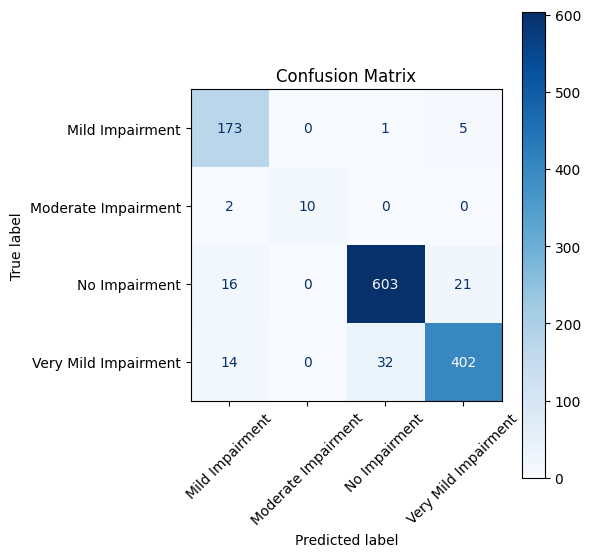

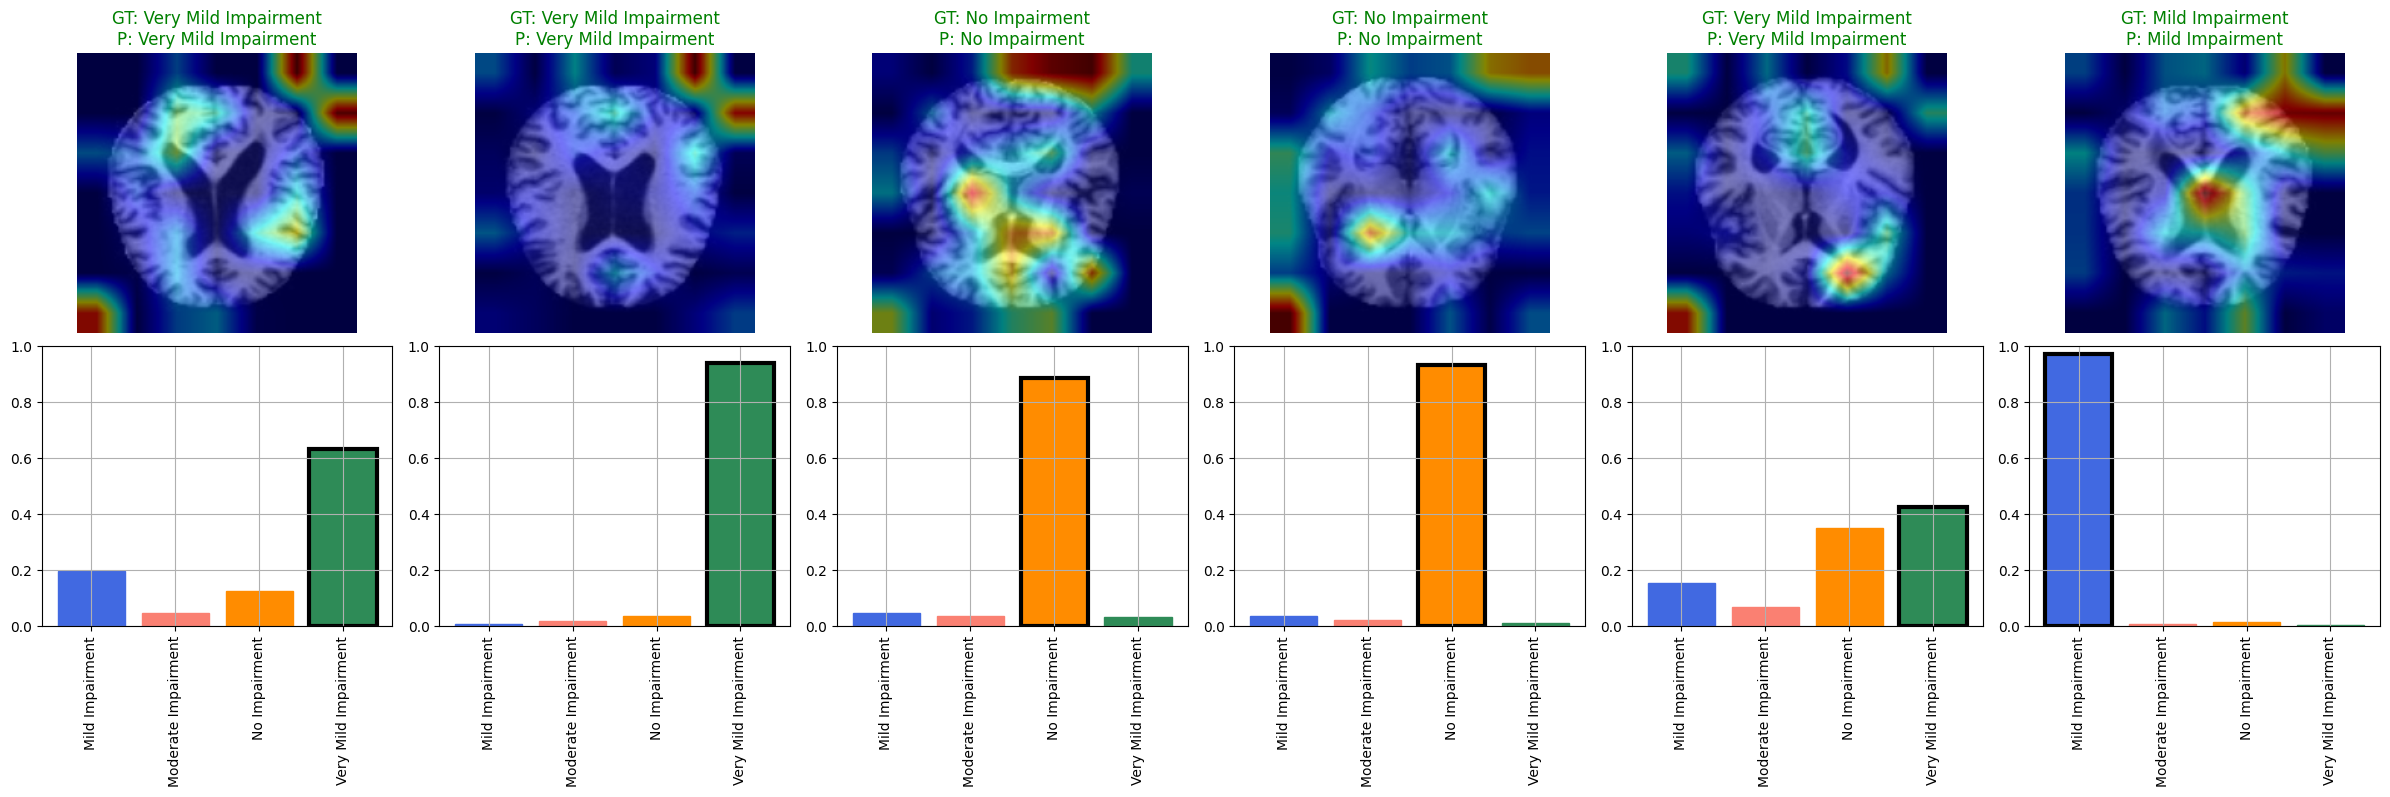

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://41d017ef1aad6cbe64.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [10]:
!pip install grad-cam==1.4.6 gradio --quiet

import os
import random
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import gradio as gr

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume these are defined:
# ts_dl   = your test DataLoader
# classes = {'No Impairment':0, 'Very Mild Impairment':1, 'Moderate Impairment':2, 'Mild Impairment':3}
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
save_dir, save_prefix = "saved_models", "mri"

# 1) Class names in correct index order
class_names = [k for k, v in sorted(classes.items(), key=lambda item: item[1])]

# 2) Load model and weights
model = timm.create_model("rexnet_150", pretrained=False, num_classes=len(classes)).to(device)
state_dict = torch.load(os.path.join(save_dir, f"{save_prefix}_best_model.pth"), map_location=device)
model.load_state_dict(state_dict)
model.eval()

# 3) Grad-CAM setup
target_layer = model.features[-1]
cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=(device.type=="cuda"))

# ==== Inference on test set ====
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in ts_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ==== Metrics & Confusion Matrix ====
correct = np.sum(np.array(all_preds)==np.array(all_labels))
total = len(all_labels)
print(f"\n=== Test Accuracy === {correct}/{total} = {100*correct/total:.2f}%\n")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ==== Grad-CAM + Bar-Chart Visualization ====
# Define distinct colors per class
class_colors = {
    'No Impairment':     'darkorange',
    'Very Mild Impairment':'seagreen',
    'Moderate Impairment':'salmon',
    'Mild Impairment':   'royalblue'
}

# Sample 6 images
sample_indices = random.sample(range(len(ts_dl.dataset)), 6)
sample_images = [ts_dl.dataset[i][0] for i in sample_indices]
sample_labels = [ts_dl.dataset[i][1] for i in sample_indices]

# Stack and predict
input_tensor = torch.stack(sample_images).to(device)
with torch.no_grad():
    outputs = model(input_tensor)
    preds = outputs.argmax(dim=1)

# Generate CAMs
cam_maps = cam(input_tensor, targets=[ClassifierOutputTarget(p.item()) for p in preds])

# Create 2×6 grid
fig, axes = plt.subplots(2, 6, figsize=(24, 8))

for i in range(6):
    # --- Top: full-image CAM overlay ---
    img = sample_images[i].cpu().permute(1,2,0).numpy()
    img = (img * np.array(std)) + np.array(mean)
    img = np.clip(img, 0, 1)

    cam_map = cv2.resize(cam_maps[i], (img.shape[1], img.shape[0]))
    overlay = show_cam_on_image(img, cam_map, use_rgb=True)

    ax_cam = axes[0, i]
    ax_cam.imshow(overlay)
    ax_cam.set_title(
        f"GT: {class_names[sample_labels[i]]}\nP: {class_names[preds[i]]}",
        color="green" if preds[i]==sample_labels[i] else "red"
    )
    ax_cam.axis("off")

    # --- Bottom: bar-chart with colored bars and predicted outline ---
    probs = torch.nn.functional.softmax(outputs[i].unsqueeze(0), dim=1)[0].cpu().numpy()
    pred_idx = preds[i].item()

    ax_bar = axes[1, i]
    for j, cls in enumerate(class_names):
        bar = ax_bar.bar(
            j, probs[j],
            color=class_colors[cls],
            edgecolor='black' if j==pred_idx else class_colors[cls],
            linewidth=3 if j==pred_idx else 1
        )
    ax_bar.set_xticks(range(len(class_names)))
    ax_bar.set_xticklabels(class_names, rotation=90)
    ax_bar.set_ylim(0, 1)
    ax_bar.grid(True)

plt.tight_layout()
plt.show()

# ==== Gradio Interface ====
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

def predict_with_gradcam(image_pil):
    img = image_pil.convert("RGB")
    tensor = test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(tensor)
        cls = out.argmax(dim=1).item()
    label = class_names[cls]

    cam_map = cam(tensor, targets=[ClassifierOutputTarget(cls)])[0]
    img_np = np.array(img).astype(np.float32)/255.0
    cam_resized = cv2.resize(cam_map, (img_np.shape[1], img_np.shape[0]))
    heatmap = show_cam_on_image(img_np, cam_resized, use_rgb=True)
    return label, heatmap

gr.Interface(
    fn=predict_with_gradcam,
    inputs=gr.Image(type="pil", label="Upload MRI"),
    outputs=[gr.Label(label="Prediction"), gr.Image(label="Grad-CAM")],
    title="ReXNet MRI Classifier",
    description="Upload an MRI image to get prediction and Grad-CAM heatmap."
).launch()
